In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math
from datetime import datetime
import os
import time
import copy

In [ ]:
input_path = '/content/drive/MyDrive/Deep Learning Group 12/Deep Learning Group 12/traffic.csv'

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [ ]:
class TrafficDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
class BidirectionalLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32):
        super(BidirectionalLSTMModel, self).__init__()

        # First Bidirectional LSTM layer
        self.lstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size1,
            batch_first=True,
            bidirectional=True
        )
        self.batch_norm1 = nn.BatchNorm1d(hidden_size1 * 2)
        self.dropout1 = nn.Dropout(0.3)

        # Second Bidirectional LSTM layer
        self.lstm2 = nn.LSTM(
            input_size=hidden_size1 * 2,
            hidden_size=hidden_size2,
            batch_first=True,
            bidirectional=True
        )
        self.batch_norm2 = nn.BatchNorm1d(hidden_size2 * 2)
        self.dropout2 = nn.Dropout(0.3)

        # Dense layers
        self.dense1 = nn.Linear(hidden_size2 * 2, 16)
        self.relu = nn.ReLU()
        self.batch_norm3 = nn.BatchNorm1d(16)
        self.dense2 = nn.Linear(16, 1)

    def forward(self, x):
        # First LSTM layer
        x, _ = self.lstm1(x)
        # Apply batch norm
        batch_size, seq_len, hidden_dim = x.shape
        x = x.contiguous().view(batch_size * seq_len, hidden_dim)
        x = self.batch_norm1(x)
        x = x.view(batch_size, seq_len, hidden_dim)
        x = self.dropout1(x)

        # Second LSTM layer
        x, _ = self.lstm2(x)
        # We only need the last output for the second LSTM
        x = x[:, -1, :]
        x = self.batch_norm2(x)
        x = self.dropout2(x)

        # Dense layers
        x = self.dense1(x)
        x = self.relu(x)
        x = self.batch_norm3(x)
        x = self.dense2(x)

        return x

In [ ]:
class HuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super(HuberLoss, self).__init__()
        self.delta = delta

    def forward(self, y_pred, y_true):
        abs_error = torch.abs(y_pred - y_true)
        quadratic = torch.min(abs_error, torch.tensor([self.delta], device=y_pred.device))
        linear = abs_error - quadratic
        loss = 0.5 * quadratic.pow(2) + self.delta * linear
        return loss.mean()

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=15, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Save model when validation loss decreases."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
class TrafficPredictor:
    def __init__(self, input_path, seq_length=24, batch_size=32):
        self.input_path = input_path
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.model = None
        self.scaler_X = None
        self.scaler_y = None
        self.feature_columns = None
        self.target_column = 'Vehicles'
        self.device = device

    def load_data(self):
        """Load and preprocess the dataset"""
        df = pd.read_csv(self.input_path)
        df['DateTime'] = pd.to_datetime(df['DateTime'])
        return df

    def preprocess_data(self, df):
        """Preprocess data with advanced feature engineering"""
        # Sort by datetime
        df = df.sort_values('DateTime')

        # Extract time-based features
        df['Hour'] = df['DateTime'].dt.hour
        df['DayOfWeek'] = df['DateTime'].dt.dayofweek
        df['Month'] = df['DateTime'].dt.month
        df['Year'] = df['DateTime'].dt.year
        df['DayOfMonth'] = df['DateTime'].dt.day
        df['WeekOfYear'] = df['DateTime'].dt.isocalendar().week

        # Create cyclical features for time variables
        df['Hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
        df['Hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
        df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
        df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)
        df['Month_sin'] = np.sin(2 * np.pi * df['Month']/12)
        df['Month_cos'] = np.cos(2 * np.pi * df['Month']/12)

        # Create one-hot encoding for junction
        junction_dummies = pd.get_dummies(df['Junction'], prefix='Junction')
        df = pd.concat([df, junction_dummies], axis=1)

        # Create lag features
        for lag in [1, 2, 3, 6, 12, 24]:
            df[f'Vehicles_lag_{lag}'] = df.groupby('Junction')['Vehicles'].shift(lag)

        # Create rolling window statistics
        for window in [6, 12, 24]:
            df[f'Vehicles_rolling_mean_{window}'] = df.groupby('Junction')['Vehicles'].transform(
                lambda x: x.rolling(window=window, min_periods=1).mean())
            df[f'Vehicles_rolling_std_{window}'] = df.groupby('Junction')['Vehicles'].transform(
                lambda x: x.rolling(window=window, min_periods=1).std())

        # Flag weekends
        df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

        # Flag holidays (simplified - just using major US holidays)
        holidays = [
            # 2015 holidays
            '2015-01-01', '2015-07-04', '2015-12-25', '2015-11-26',
            # 2016 holidays
            '2016-01-01', '2016-07-04', '2016-12-25', '2016-11-24',
            # 2017 holidays
            '2017-01-01', '2017-07-04', '2017-12-25', '2017-11-23'
        ]
        df['IsHoliday'] = df['DateTime'].dt.strftime('%Y-%m-%d').isin(holidays).astype(int)

        # Fill NaN values created by lag features
        df = df.fillna(method='bfill')

        return df

    def create_sequences(self, data, target, seq_length):
        """Create sequences for LSTM model"""
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length])
            y.append(target[i + seq_length])
        return np.array(X), np.array(y)

    def train(self, epochs=100):
        """Train the LSTM model"""
        # Load and preprocess data
        df = self.load_data()
        df = self.preprocess_data(df)

        # Split data by time (train: 2015-2016, test: 2017)
        train_data = df[df['DateTime'].dt.year < 2017].copy()
        test_data = df[df['DateTime'].dt.year == 2017].copy()

        print(f"Training data shape: {train_data.shape}")
        print(f"Testing data shape: {test_data.shape}")

        # Select features for model (excluding DateTime and original Junction column)
        self.feature_columns = [col for col in df.columns
                               if col not in ['DateTime', 'Junction', 'ID', 'Vehicles']]

        # Add the target column for lag features
        self.feature_columns += [col for col in df.columns if 'Vehicles_lag' in col or 'Vehicles_rolling' in col]

        print(f"Selected features: {len(self.feature_columns)} features")

        # Scale the data
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()

        # Fit scalers on training data only
        train_features = self.scaler_X.fit_transform(train_data[self.feature_columns])
        train_target = self.scaler_y.fit_transform(train_data[[self.target_column]])

        # Transform test data
        test_features = self.scaler_X.transform(test_data[self.feature_columns])
        test_target = self.scaler_y.transform(test_data[[self.target_column]])

        # Create sequences
        X_train, y_train = self.create_sequences(train_features, train_target, self.seq_length)
        X_test, y_test = self.create_sequences(test_features, test_target, self.seq_length)

        print(f"X_train shape: {X_train.shape}")
        print(f"y_train shape: {y_train.shape}")

        # Create validation split
        val_size = int(0.2 * len(X_train))
        X_val = X_train[-val_size:]
        y_val = y_train[-val_size:]
        X_train = X_train[:-val_size]
        y_train = y_train[:-val_size]

        # Create datasets and dataloaders
        train_dataset = TrafficDataset(X_train, y_train)
        val_dataset = TrafficDataset(X_val, y_val)
        test_dataset = TrafficDataset(X_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size)

        # Initialize model
        input_size = X_train.shape[2]  # Number of features
        self.model = BidirectionalLSTMModel(input_size).to(self.device)
        print(self.model)

        # Create model checkpoint directory
        checkpoint_dir = 'model_checkpoints'
        os.makedirs(checkpoint_dir, exist_ok=True)
        model_path = os.path.join(checkpoint_dir, 'best_model.pt')

        # Loss function and optimizer
        criterion = HuberLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)

        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=7,
            min_lr=1e-6,
            verbose=True
        )

        # Early stopping
        early_stopping = EarlyStopping(
            patience=15,
            verbose=True,
            path=model_path
        )

        # Training history
        history = {
            'train_loss': [],
            'val_loss': []
        }

        # Training loop
        start_time = time.time()
        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = 0.0

            for inputs, targets in train_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = self.model(inputs)
                loss = criterion(outputs, targets)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * inputs.size(0)

            train_loss = train_loss / len(train_loader.dataset)

            # Validation phase
            self.model.eval()
            val_loss = 0.0

            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(self.device), targets.to(self.device)

                    # Forward pass
                    outputs = self.model(inputs)
                    loss = criterion(outputs, targets)

                    val_loss += loss.item() * inputs.size(0)

                val_loss = val_loss / len(val_loader.dataset)

            # Adjust learning rate
            scheduler.step(val_loss)

            # Check early stopping
            early_stopping(val_loss, self.model)

            # Store loss history
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)

            # Print progress
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

            if early_stopping.early_stop:
                print("Early stopping triggered")
                break

        # Load the best model
        self.model.load_state_dict(torch.load(model_path))

        # Calculate training time
        training_time = time.time() - start_time
        print(f"Training complete in {training_time:.2f} seconds")

        # Evaluate on test set
        self.model.eval()
        y_pred = []
        y_true = []

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)

                y_pred.extend(outputs.cpu().numpy())
                y_true.extend(targets.cpu().numpy())

        y_pred = np.array(y_pred)
        y_true = np.array(y_true)

        # Inverse transform to get actual values
        y_test_inv = self.scaler_y.inverse_transform(y_true)
        y_pred_inv = self.scaler_y.inverse_transform(y_pred)

        # Calculate metrics
        rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
        mae = mean_absolute_error(y_test_inv, y_pred_inv)
        r2 = r2_score(y_test_inv, y_pred_inv)

        print(f"Test RMSE: {rmse:.2f}")
        print(f"Test MAE: {mae:.2f}")
        print(f"Test R² Score: {r2:.4f}")

        # Return test data with predictions for visualization
        test_with_preds = test_data.iloc[self.seq_length:self.seq_length+len(y_pred_inv)].copy()
        test_with_preds['Predicted'] = y_pred_inv.flatten()

        return history, test_with_preds, y_test_inv, y_pred_inv

    def visualize_results(self, history, test_with_preds, y_test_inv, y_pred_inv):
        """Visualize training history and predictions"""
        # Plot training history
        plt.figure(figsize=(12, 6))
        plt.plot(history['train_loss'], label='Training Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot predictions vs actual for a sample period
        sample_size = 168  # One week
        plt.figure(figsize=(15, 6))
        plt.plot(y_test_inv[:sample_size], label='Actual')
        plt.plot(y_pred_inv[:sample_size], label='Predicted')
        plt.title('Traffic Prediction: Actual vs Predicted')
        plt.xlabel('Hours')
        plt.ylabel('Number of Vehicles')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot predictions for each junction
        for junction in test_with_preds['Junction'].unique():
            junction_data = test_with_preds[test_with_preds['Junction'] == junction]

            if len(junction_data) > 0:
                plt.figure(figsize=(15, 6))
                plt.plot(junction_data['DateTime'], junction_data['Vehicles'],
                         label=f'Actual - Junction {junction}')
                plt.plot(junction_data['DateTime'], junction_data['Predicted'],
                         label=f'Predicted - Junction {junction}')
                plt.title(f'Traffic Prediction for Junction {junction}')
                plt.xlabel('Date')
                plt.ylabel('Number of Vehicles')
                plt.legend()
                plt.grid(True)
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()

                # Calculate junction-specific metrics
                junction_rmse = math.sqrt(mean_squared_error(
                    junction_data['Vehicles'], junction_data['Predicted']))
                junction_r2 = r2_score(junction_data['Vehicles'], junction_data['Predicted'])
                print(f"Junction {junction} - RMSE: {junction_rmse:.2f}, R²: {junction_r2:.4f}")

        # Plot error distribution
        errors = y_test_inv.flatten() - y_pred_inv.flatten()
        plt.figure(figsize=(12, 6))
        sns.histplot(errors, kde=True)
        plt.title('Error Distribution')
        plt.xlabel('Prediction Error')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

        # Plot actual vs predicted scatter plot
        plt.figure(figsize=(10, 10))
        plt.scatter(y_test_inv, y_pred_inv, alpha=0.5)
        plt.plot([y_test_inv.min(), y_test_inv.max()],
                 [y_test_inv.min(), y_test_inv.max()],
                 'r--', lw=2)
        plt.title('Actual vs Predicted')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.grid(True)
        plt.show()

    def save_model(self, filepath='traffic_lstm_model_pytorch.pt'):
        """Save the trained model"""
        if self.model is not None:
            torch.save({
                'model_state_dict': self.model.state_dict(),
                'scaler_X': self.scaler_X,
                'scaler_y': self.scaler_y,
                'feature_columns': self.feature_columns,
                'seq_length': self.seq_length
            }, filepath)
            print(f"Model saved to {filepath}")
        else:
            print("No model to save. Train the model first.")

    def load_model(self, filepath='traffic_lstm_model_pytorch.pt'):
        """Load a trained model"""
        if not os.path.exists(filepath):
            print(f"Model file {filepath} not found.")
            return False

        checkpoint = torch.load(filepath, map_location=self.device)

        # Load model parameters
        input_size = len(checkpoint['feature_columns'])
        self.model = BidirectionalLSTMModel(input_size).to(self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])

        # Load scalers and other attributes
        self.scaler_X = checkpoint['scaler_X']
        self.scaler_y = checkpoint['scaler_y']
        self.feature_columns = checkpoint['feature_columns']
        self.seq_length = checkpoint['seq_length']

        self.model.eval()
        print(f"Model loaded from {filepath}")
        return True

    def predict(self, new_data):
        """Make predictions on new data"""
        if self.model is None:
            print("No model available. Train or load a model first.")
            return None

        # Preprocess new data
        processed_data = self.preprocess_data(new_data)

        # Extract features
        features = self.scaler_X.transform(processed_data[self.feature_columns])

        # Create sequences
        X_new = []
        for i in range(len(features) - self.seq_length + 1):
            X_new.append(features[i:i + self.seq_length])
        X_new = np.array(X_new)

        # Convert to torch tensor
        X_new_tensor = torch.tensor(X_new, dtype=torch.float32).to(self.device)

        # Set model to evaluation mode
        self.model.eval()

        # Make predictions
        with torch.no_grad():
            predictions = self.model(X_new_tensor).cpu().numpy()

        # Inverse transform predictions
        predictions_inv = self.scaler_y.inverse_transform(predictions)

        return predictions_inv

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.


<ipython-input-8-71bd02592730>:70: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')


Training data shape: (30744, 34)
Testing data shape: (17376, 34)
Selected features: 42 features
X_train shape: (30720, 24, 42)
y_train shape: (30720, 1)
BidirectionalLSTMModel(
  (lstm1): LSTM(42, 64, batch_first=True, bidirectional=True)
  (batch_norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (lstm2): LSTM(128, 32, batch_first=True, bidirectional=True)
  (batch_norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dense1): Linear(in_features=64, out_features=16, bias=True)
  (relu): ReLU()
  (batch_norm3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense2): Linear(in_features=16, out_features=1, bias=True)
)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Validation loss decreased (inf --> 0.434647). Saving model...
Epoch 1/25, Train Loss: 0.2309, Val Loss: 0.4346
Validation loss decreased (0.434647 --> 0.414867). Saving model...
Epoch 2/25, Train Loss: 0.2021, Val Loss: 0.4149
EarlyStopping counter: 1 out of 15
Epoch 3/25, Train Loss: 0.1973, Val Loss: 0.4187
EarlyStopping counter: 2 out of 15
Epoch 4/25, Train Loss: 0.1930, Val Loss: 0.4170
Validation loss decreased (0.414867 --> 0.403266). Saving model...
Epoch 5/25, Train Loss: 0.1872, Val Loss: 0.4033
EarlyStopping counter: 1 out of 15
Epoch 6/25, Train Loss: 0.1854, Val Loss: 0.4036
Validation loss decreased (0.403266 --> 0.396200). Saving model...
Epoch 7/25, Train Loss: 0.1827, Val Loss: 0.3962
Validation loss decreased (0.396200 --> 0.388820). Saving model...
Epoch 8/25, Train Loss: 0.1804, Val Loss: 0.3888
EarlyStopping counter: 1 out of 15
Epoch 9/25, Train Loss: 0.1776, Val Loss: 0.3893
EarlyStopping counter: 2 out of 15
Epoch 10/25, Train Loss: 0.1765, Val Loss: 0.3973
Vali

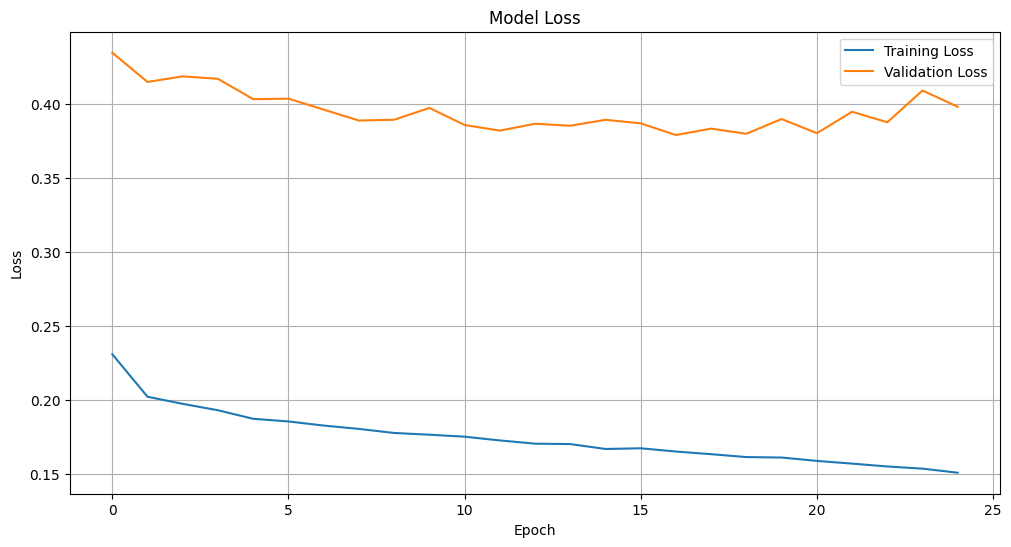

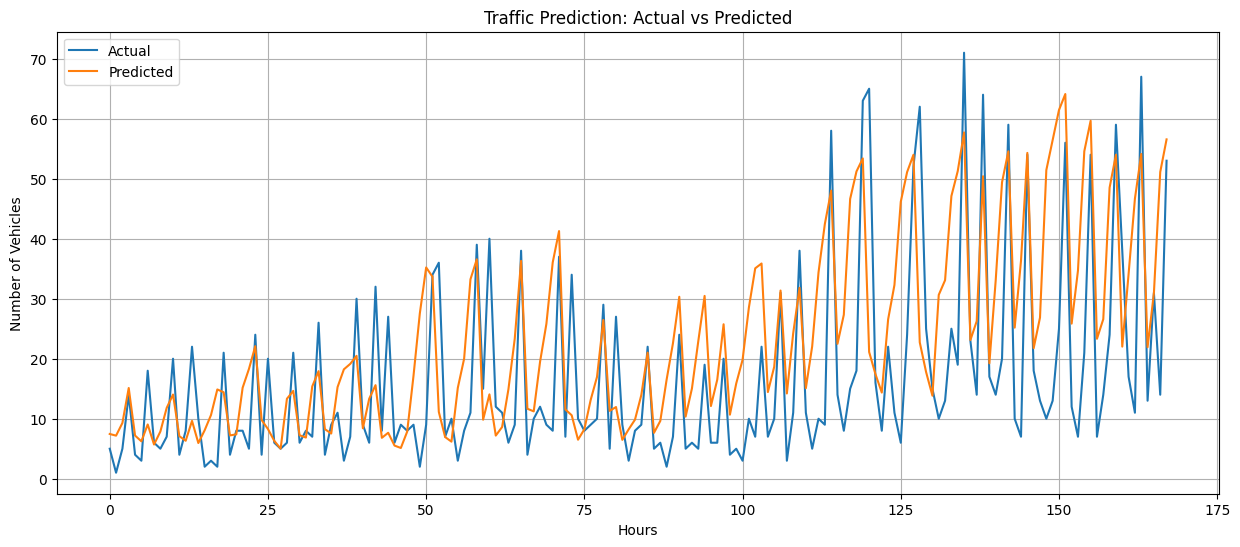

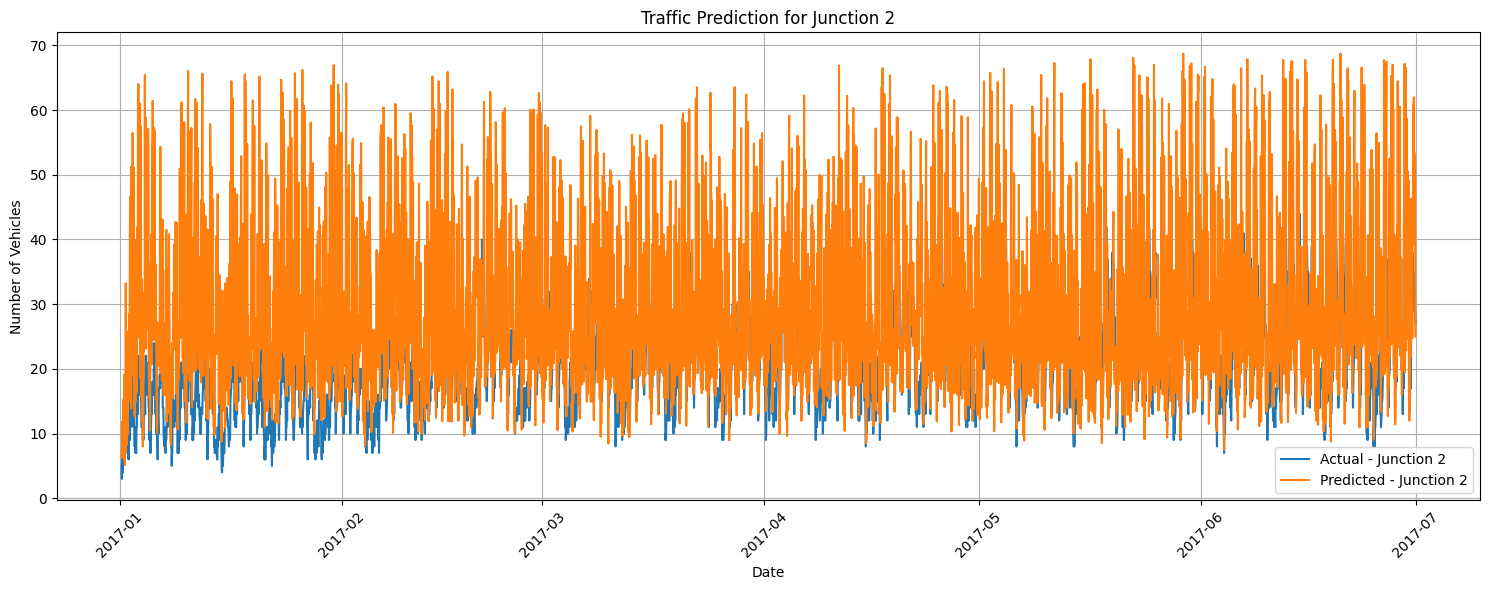

Junction 2 - RMSE: 15.83, R²: -2.6890


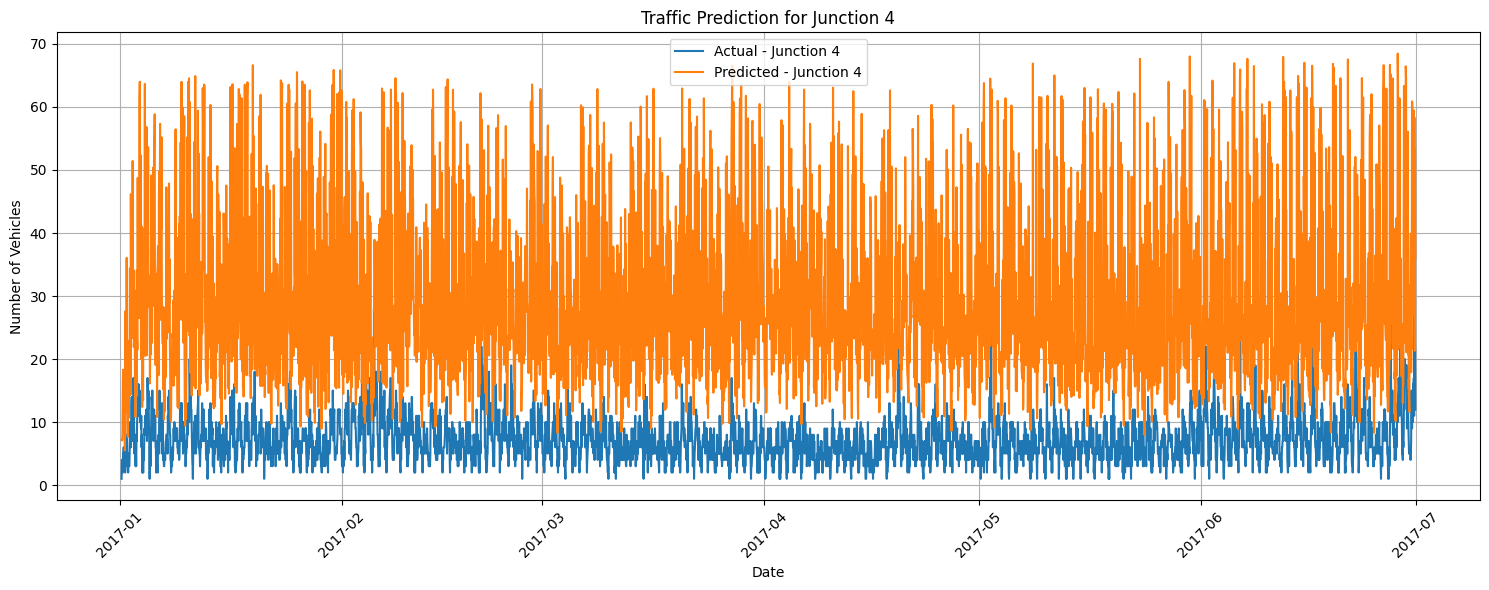

Junction 4 - RMSE: 25.21, R²: -50.3218


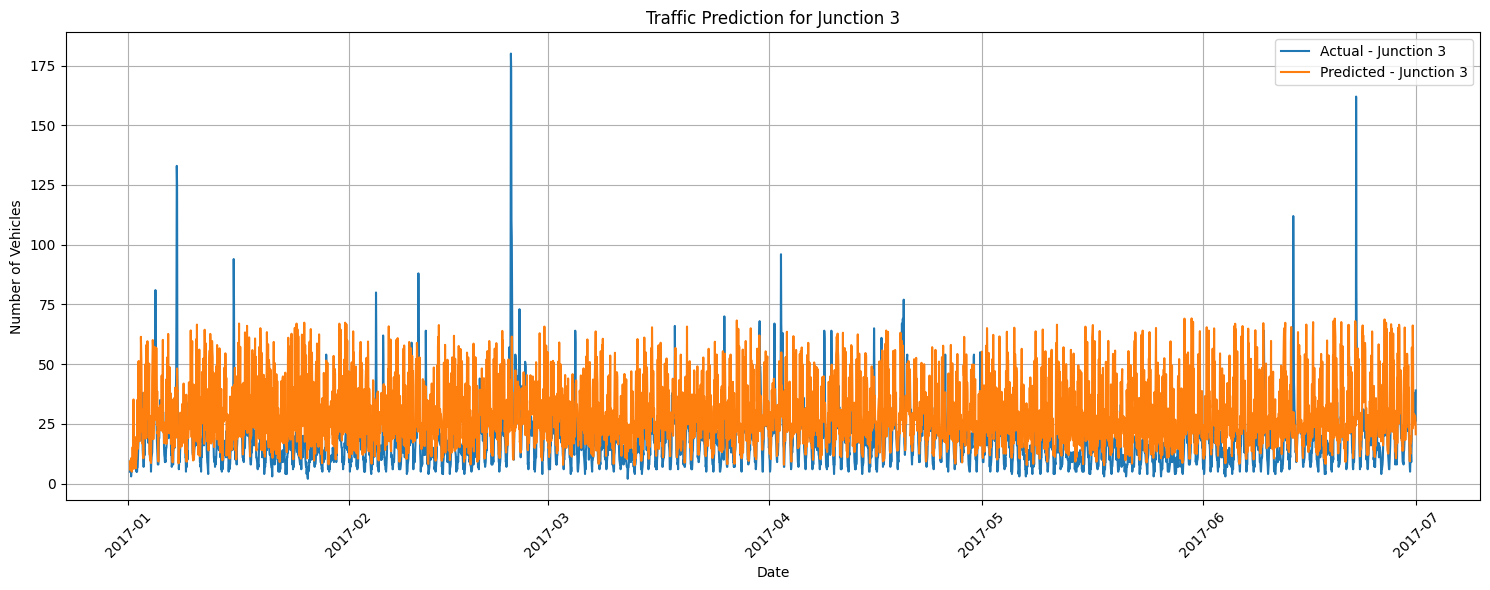

Junction 3 - RMSE: 18.69, R²: -1.6787


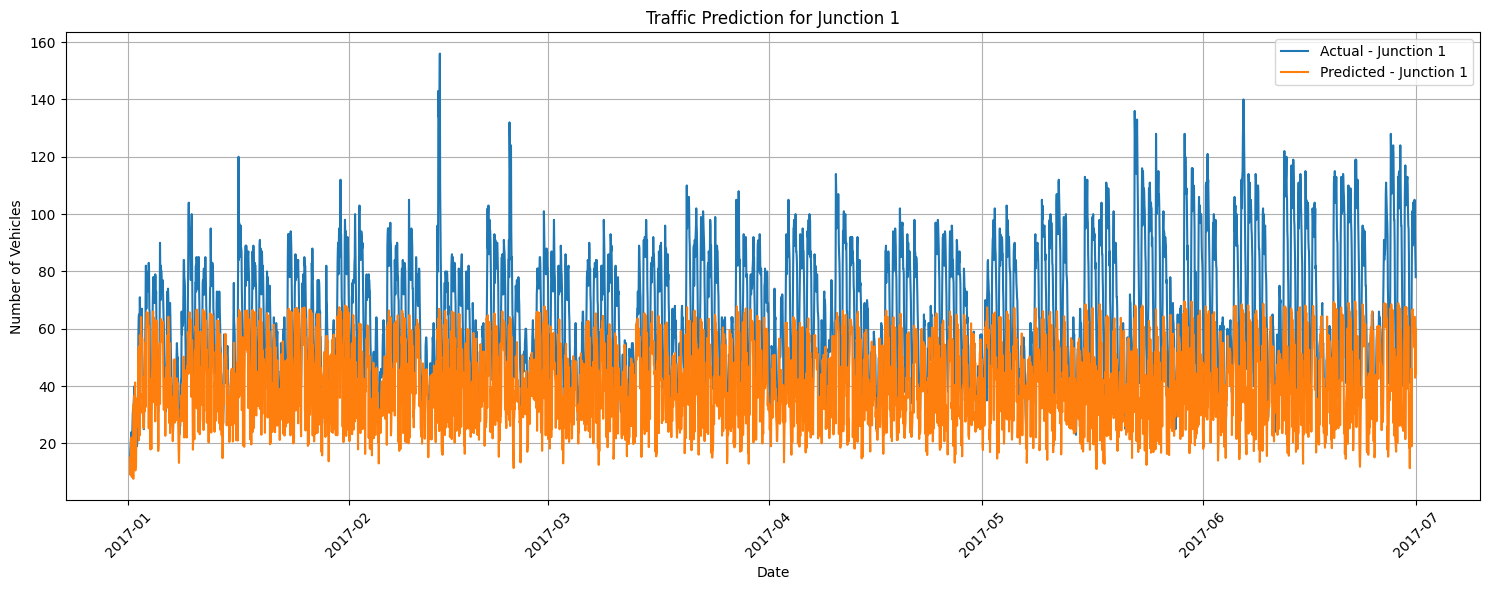

Junction 1 - RMSE: 30.09, R²: -0.7427


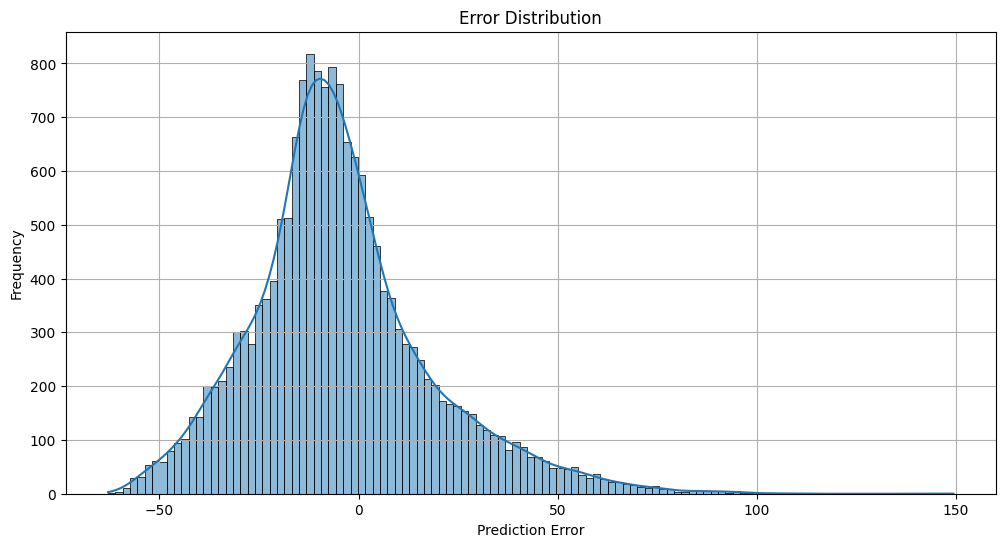

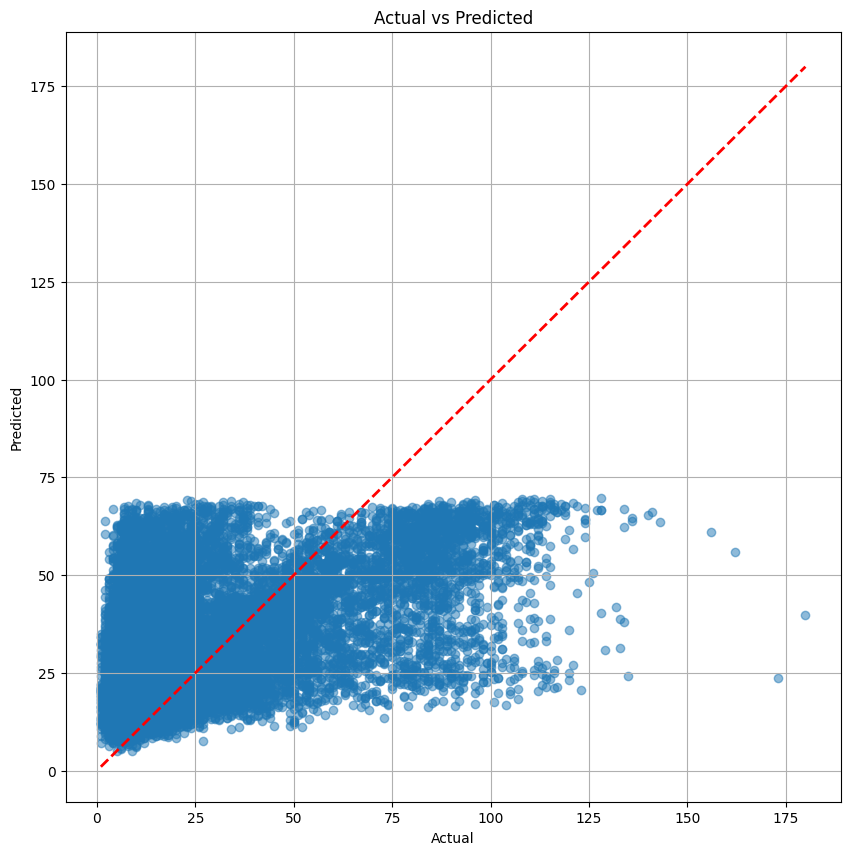

Model saved to traffic_lstm_model_pytorch.pt


In [ ]:
if __name__ == "__main__":
    # Mount Google Drive (for Colab)
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print("Google Drive mounted successfully.")
    except:
        print("Not running in Google Colab or Drive already mounted.")

    # Initialize the predictor
    input_path = '/content/drive/MyDrive/Deep Learning Group 12/Deep Learning Group 12/traffic.csv'
    predictor = TrafficPredictor(input_path=input_path, seq_length=24, batch_size=32)

    # Train the model
    history, test_with_preds, y_test, y_pred = predictor.train(epochs=25)

    # Visualize results
    predictor.visualize_results(history, test_with_preds, y_test, y_pred)

    # Save the model
    predictor.save_model('traffic_lstm_model_pytorch.pt')